<a href="https://colab.research.google.com/github/Chiaradisanto/AI_PROJECT/blob/main/Fold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
batch_size=16

In [3]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
train_img_path = "/gdrive/MyDrive/TESI/FOLD2/train/train_images"
train_mask_path = "/gdrive/MyDrive/TESI/FOLD2/train/train_masks"

val_img_path = "/gdrive/MyDrive/TESI/FOLD2/train/val_images"
val_mask_path = "/gdrive/MyDrive/TESI/FOLD2/train/val_masks"

In [5]:
seed=42
from keras.preprocessing.image import ImageDataGenerator


img_data_gen_args = dict(rescale=1./255,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict( rescale=1./255,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect'
                     
                     ) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

In [6]:
image_generator = image_data_generator.flow_from_directory(train_img_path, 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           color_mode = 'grayscale',
                                                           target_size=(256,256),
                                                           
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_generator = mask_data_generator.flow_from_directory(train_mask_path, 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',
                                                         target_size=(256,256)  , #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory(val_img_path, 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale', 
                                                               target_size=(256,256),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(256,256),
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 2942 images belonging to 1 classes.
Found 2942 images belonging to 1 classes.
Found 517 images belonging to 1 classes.
Found 517 images belonging to 1 classes.


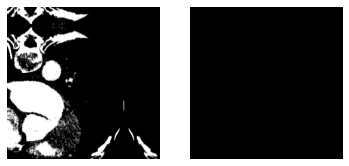

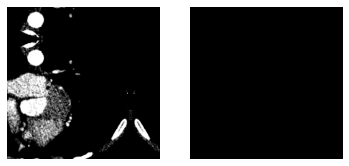

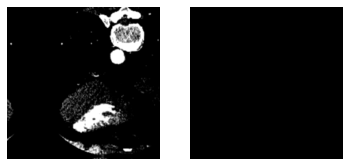

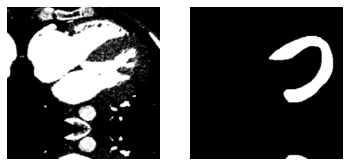

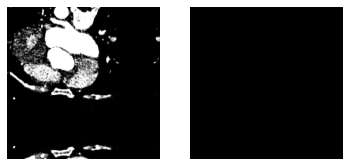

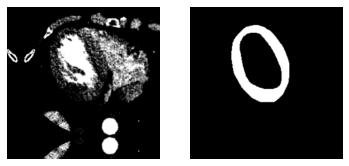

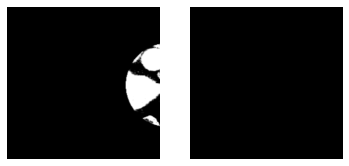

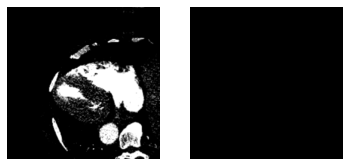

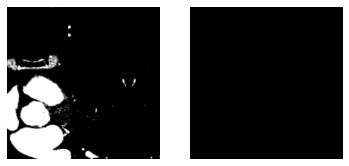

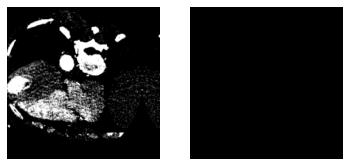

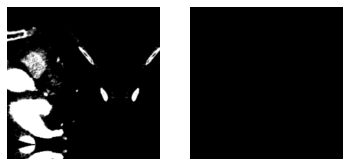

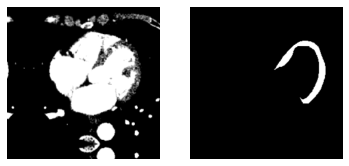

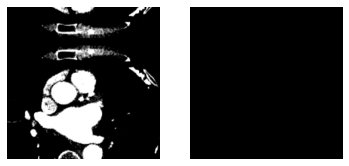

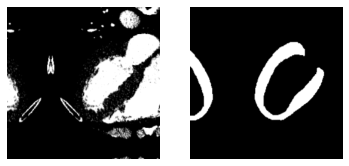

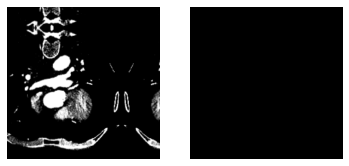

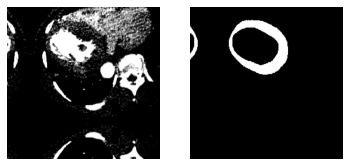

In [7]:
x, y = train_generator.__next__()

for i in range(0,16):
    image = x[i,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

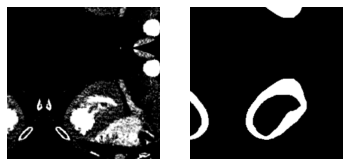

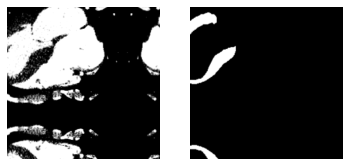

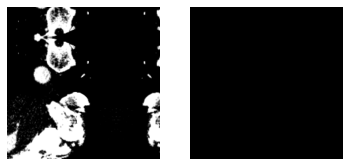

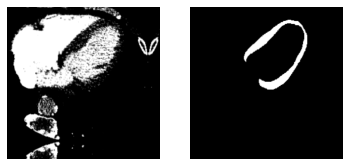

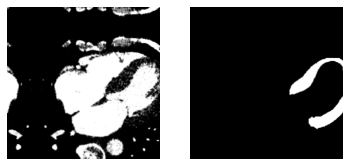

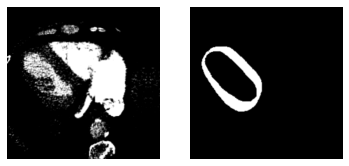

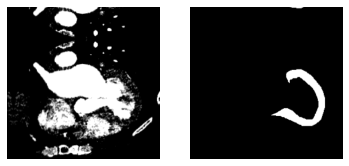

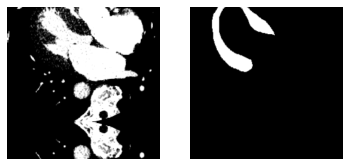

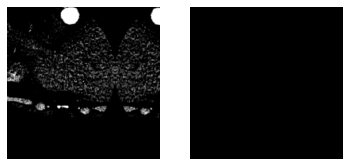

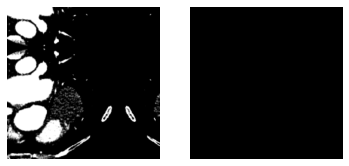

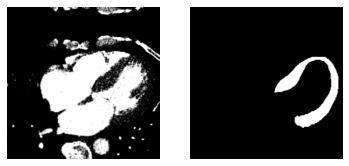

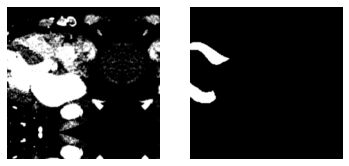

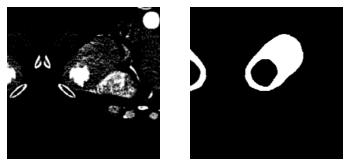

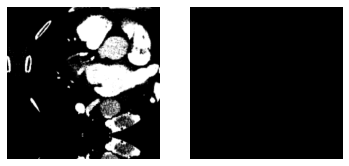

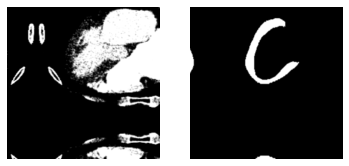

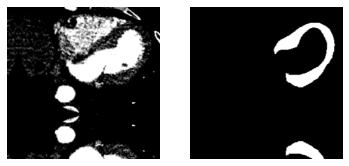

In [8]:
x, y = val_generator.__next__()

for i in range(0,16):
    image = x[i,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [9]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TESI/FOLD2/train/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TESI/FOLD2/train/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(256, 256, 1)


In [10]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1= tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1= tf.keras.layers.BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2= tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2= tf.keras.layers.BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3= tf.keras.layers.BatchNormalization()(c3)

c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3= tf.keras.layers.BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4= tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4= tf.keras.layers.BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5= tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5= tf.keras.layers.BatchNormalization()(c5)
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [11]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return ((2. * intersection + smooth) / (K.sum(y_true_f) +
            K.sum(y_pred_f) + smooth))


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coefficient(y_true, y_pred)

In [13]:
LR = 0.00001
optim = tf.keras.optimizers.Adam(LR)

In [14]:
metrics = ['Accuracy', 'Precision', 'Recall',  dice_coefficient ]


In [15]:
model.compile(optimizer=optim, loss=dice_coefficient_loss, metrics=metrics)


In [16]:
history=model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_generator,
          validation_steps=val_steps_per_epoch)

Epoch 1/50
183/183 [==============================] - 692s 4s/step - loss: 0.9505 - Accuracy: 0.3885 - precision: 0.0301 - recall: 0.7417 - dice_coefficient: 0.0495 - val_loss: 0.9546 - val_Accuracy: 0.8175 - val_precision: 0.0445 - val_recall: 0.3417 - val_dice_coefficient: 0.0444
Epoch 2/50
183/183 [==============================] - 71s 387ms/step - loss: 0.8200 - Accuracy: 0.8201 - precision: 0.0912 - recall: 0.6695 - dice_coefficient: 0.1800 - val_loss: 0.8196 - val_Accuracy: 0.9124 - val_precision: 0.1349 - val_recall: 0.4801 - val_dice_coefficient: 0.1805
Epoch 3/50
183/183 [==============================] - 71s 388ms/step - loss: 0.5651 - Accuracy: 0.9677 - precision: 0.4151 - recall: 0.5233 - dice_coefficient: 0.4349 - val_loss: 0.6102 - val_Accuracy: 0.9663 - val_precision: 0.3676 - val_recall: 0.5171 - val_dice_coefficient: 0.3926
Epoch 4/50
183/183 [==============================] - 71s 389ms/step - loss: 0.5033 - Accuracy: 0.9720 - precision: 0.4890 - recall: 0.5524 - dice_

In [17]:
model.save('/gdrive/MyDrive/TESI/FOLD2/train/model/Unet.h5')

In [18]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/FOLD2/train/model/Unet.h5", compile=False)

In [19]:
a, b = val_generator.__next__()


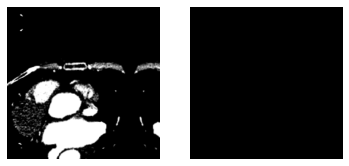

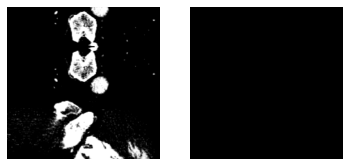

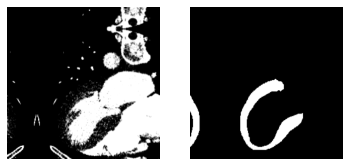

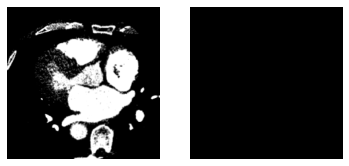

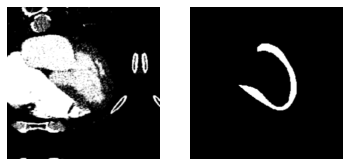

In [20]:
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

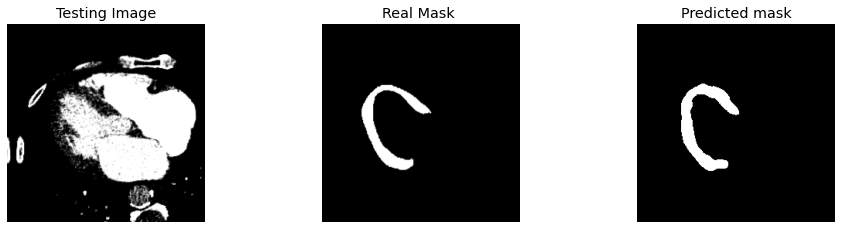

In [24]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [25]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7895255


In [26]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1.0
0.4988861
0.78044116
0.49978638
0.7528837
0.7786437
0.49928284
0.75571567
0.73639834
0.7895255
0.7781098
1.0
1.0
0.9078126
0.4820099
1.0
Mean IoU is:  [0.68829125]
